# Euler Beam Theory

## Theory

The deflection of a beam in 1 dimension is given by the partial differential equation, described by $w(x)$ being the deflection, $E(x)$ the Young's modulus of the beam material, $I(x)$ the Area Moment of Inertia and $q(x)$ the load on the beam:
\begin{equation}
q(x) - \mu\frac{\partial^2 w}{\partial t^2} = \frac{\partial^2}{\partial x^2}(E(x)I(x)\frac{\partial^2 w}{\partial x^2})
\end{equation}
If we consider a static situation, the second order time derivative vanishes and we are left with the following ordinary differential equation:
\begin{equation}
\frac{d^2}{d x^2}(E(x)I(x)\frac{d^2 w}{d x^2}) = q(x)
\end{equation}
In ideal cases, the Young's modulus and Area Moment of Inertia can be considered a constant in $x$ and the ODE reduces down to a $4^{th}$ order ODE as follows:
\begin{equation}
EI\frac{d^4 w}{d x^4} = q(x)
\end{equation}

## Classical Implementation

This ODE can be solved both analytically as well as numerically using Finite Differences Method. The analytical solution to the ODE is given by the equations below with the following assumptions:
1. The beam is simply supported on both sides.
2. The beam has a length L(5m), thickness b and height h. Then, the area moment of inertia is given by $I = \frac{bh^3}{12} = 3.375 \times 10^{-4} m^4$
3. The Young's modulus is 20GPa.
4. The load is uniformly distributed along the beam, with $q(x) = 12kN/m$
5. The slope of the beam is small (small deformed angle)
6. Any section of the beam that was flat before deformation will remain flat after deformation.
\begin{equation}
w(x) = \frac{q}{24EI}(2Lx^3 - x^4 - L^3x)
\end{equation}
Using Finite differences with 6 segments, the linear system $Ax=b$ is as follows.
\begin{equation}
\begin{bmatrix}
1 &0  &0  & 0 & 0 & 0 & 0\\ 
-4 & 5 & -4 & 1 & 0 & 0 &0\\ 
1 & -4 & 6 & -4 & 1 & 0 & 0\\ 
0 & 1 & -4 & 6 & -4 & 1 & 0\\ 
0 & 0 & 1 & -4 & 6 & -4 & 1\\ 
0 & 0 & 0 & 1 & -4 & 5 & -4\\ 
0 & 0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
\begin{pmatrix}
w_0\\ 
w_1\\ 
w_2\\ 
w_3\\ 
w_4\\ 
w_5\\ 
w_6
\end{pmatrix} = -\frac{qh^4}{EI}\begin{pmatrix}
1\\ 
1\\ 
1\\ 
1\\ 
1\\ 
1\\ 
1
\end{pmatrix}
\end{equation}
where $h = \frac{L}{n+1}$

In [1]:
import numpy as np
from scipy.linalg import expm, ishermitian
from qiskit import *
from qiskit.quantum_info.operators import Operator
from qiskit.extensions import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import SwapGate, RYGate, QFT
from copy import deepcopy
import math
import sys
%matplotlib inline
import matplotlib.pyplot as plt
import pylatexenc

### FDM Solution

In [2]:
# Define alpha as the value before the b vector
alpha = 12000*((5/7)**4)/(2e09 * 3.375e-4)

A = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        if i == j:
            A[i,j] = 6
        elif j == i+1 or j == i-1:
            A[i,j] = -4
        elif j == i-2 or j == i+2:
            A[i,j] = 1
        else:
            pass
    if i == 0 or i ==4:
        for j in range(5):
            A[i,j] = 0
A[0,0] = 1
A[4,4] = 1
A[1,1] -= 1
A[3,3] -= 1

b = np.ones(5)
b[0] = 0
b[4] = 0
# Need to multiply right side vector by -alpha on exit!

In [3]:
print(A,b)

[[ 1.  0.  0.  0.  0.]
 [-4.  5. -4.  1.  0.]
 [ 1. -4.  6. -4.  1.]
 [ 0.  1. -4.  5. -4.]
 [ 0.  0.  0.  0.  1.]] [0. 1. 1. 1. 0.]


[-0.        -0.0046277 -0.0046277 -0.0046277 -0.       ]


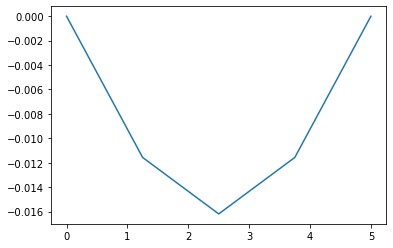

In [4]:
w = np.linalg.solve(A,-alpha*b)
print(-alpha*b)
x = np.linspace(0,5,5)
plt.plot(x,w)

[ 0.         -0.01156925 -0.01619695 -0.01156925  0.        ]


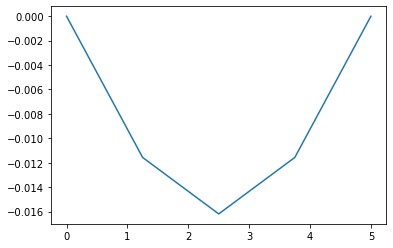

In [5]:
A_herm = A[1:-1,1:-1]
b_test = b[1:-1]
w_test = np.linalg.solve(A_herm,-alpha*b_test)
w_n = np.zeros(5)
for i in range(len(w_test)):
    w_n[i+1] = w_test[i] 
print(w_n)
plt.plot(x,w_n)

In [6]:
print(x)

[0.   1.25 2.5  3.75 5.  ]


## Quantum Implementation

### Building the Circuit

Steps:
1. Hermitianize the input matrix and adjust the right side vector accordingly.
2. Build the circuit according to the HHL Algorithm

**Hermitianization of the Linear System**

In [7]:
# Define a function to hermitianize the matrix
def hermitianize(mat):
    herm = np.zeros((2*mat.shape[0], 2*mat.shape[1]))
    print(herm.shape)
    mat_conj = mat.getH()
    for i in range(herm.shape[0]):
        for j in range(herm.shape[0]):
            if i < mat.shape[0] and j >= mat.shape[0]:
                herm[i,j] = mat[i,j-mat.shape[0]]
            elif i >= mat.shape[0] and j < mat.shape[0]:
                herm[i,j] = mat_conj[i-mat.shape[0],j]
            else:
                pass
    return herm
            
# Check if matrix size is a power of 2, if not prepare matrix to size
# Check if the matrix is hermitian, if not Hermitianiz the matrix
def hermitian_matrix(A,b):
    if A.shape[0] != A.shape[1]:
        print('Not a Square Matrix')
        sys.exit(0)
    if not isinstance(np.log2(A.shape[0]), int):
        A_new = np.zeros((A.shape[0] + 1, A.shape[0]+1))
        b_new = np.zeros(A.shape[0] + 1)
        print(A_new.shape[0])
        for i in range(A_new.shape[0]):
            for j in range(A_new.shape[0]):
                if (i < A.shape[0]) and (j < A.shape[0]):
                    A_new[i,j] = A[i,j]
                else:
                    pass
            if i >= A.shape[0]:
                A_new[i,i] = 1
            if i < A.shape[0]:
                b_new[i] = b[i]
        A_new = np.asmatrix(A_new)
    else:
        A_new = np.asmatrix(A)
        b_new = b
    if not ishermitian(A_new):
        # Hermitianize the input matrix
        A_hermitian = hermitianize(A_new)
        # Adjust the right side vector with additional zeros
        b_adjust = np.zeros(A_hermitian.shape[0])
        for i in range(len(b_new)):
            b_adjust[i] = b_new[i]
        # Change hermitian matrix data type from matrix to array
        A_hermitian = np.asarray(A_hermitian)
    else:
        # Do nothing, the matrix is hermitian
        A_hermitian = np.asarray(A_new)
        b_adjust = b_new
    return A_hermitian, b_adjust

In [8]:
A_herm

array([[ 5., -4.,  1.],
       [-4.,  6., -4.],
       [ 1., -4.,  5.]])

In [9]:
A_herm, b_herm = hermitian_matrix(A_herm,b_test)

4


In [10]:
b_herm = -alpha*b_herm
b_herm

array([-0.0046277, -0.0046277, -0.0046277, -0.       ])

**Preparation Step**

Also check the condition number of the hermitian matrix and other properties of the matrix

In [11]:
# Normalize the vector and apply the same factor to the matrix
beta = np.linalg.norm(b_herm,2)
b_herm = -b_herm/beta
A_herm = A_herm/beta

# Condition number and Eigenvalues
print(np.linalg.cond(A_herm))
print(np.linalg.eigvals(A_herm))
print(b_herm)

33.97056274847708
[1454.30470271  499.03847868   42.81073332  124.75961967]
[0.57735027 0.57735027 0.57735027 0.        ]


In [55]:
# Convert the right side vector to positive
b_herm = -1*b_herm

In [12]:
np.savetxt('a_herm.txt',A_herm)
np.savetxt('b_herm.txt',b_herm)

Define the parameters needed to construct the circuit

In [23]:
# Number of Qubits needed to hold eigenvalues
eig_num = 4
# Number of Qubits needed to hold right side vector
b_num = int(np.log2(len(b_herm)))
# Hamiltonian Parameter --> Defines the total time for the Hamiltonial simulations
t = (1 - 2**(-1*eig_num))*0.75*np.pi/4
print(t)
# Rotation parameter --> From paper on Quantum Circuit Design choose value between 5 and 6 for best results. We select 5 (for higher success rate)
r = 5
# New implementation via arcsin function to get theta values
# Total number of circuit runs
shots = 80000

0.36815538909255385


**Building the Quantum Circuit for Linear System**

In [14]:
def construct_quantum_circuit(r,t):
    #=========================== Quantum Circuit ========================================#
    # Qubits
    anc = QuantumRegister(1,'anc')
    a_reg = QuantumRegister(eig_num, 'Eig_Reg')
    b_reg = QuantumRegister(b_num, 'b_reg')
    # Classical Bits
    cbit_anc = ClassicalRegister(1,'ancilla_cbit')
    cbit_b = ClassicalRegister(b_num, 'regB')
    # Initialize circuit
    circuit = QuantumCircuit(anc,a_reg,b_reg,cbit_anc,cbit_b)
    # Initialize state b
    init = Initialize(list(b_herm))
    circuit.append(init,b_reg)
    circuit.draw()
    # Apply H-gate on quantum register a
    circuit.h(a_reg)
    # Apply controlled Hamiltonian operators on quantum register b
    for i in range(eig_num):
        time = t/(2**(eig_num-1))
        U = HamiltonianGate(A_herm, time)
        G = U.control(1)
        qubit = [i+1]+[eig_num+j+1 for j in range(b_num)]
        circuit.append(G,qubit)
    
    # Apply inverse Quantum Fourier Transform
    iqft = QFT(eig_num, approximation_degree=0, do_swaps=True, inverse=True, name='IQFT')
    circuit.append(iqft, a_reg)
    # Swap Qubits in quantum register A
    G = SwapGate()
    circuit.append(G,[a_reg[1],a_reg[eig_num-1]])
    
    #=================================Conditioned Rotation of Ancilla==============================#
    # Apply Y Rotations in quantum register A
    
    ## Applying conditional rotation based Hamiltonian simulation time --> Does not work too well!
    #for i in range(eig_num):
    #    theta = 2*np.pi*i/t
    #    U = RYGate(theta).control(1)
    #    circuit.append(U,[i+1,0])
    
    # Applying conditional rotation based on the number of qubits in the eigenvalue register --> Works with scaling factor at output
    # Conventional Factor of proportionality does not work!
    #for i in range(eig_num):
    #    theta = np.pi/(2**(eig_num - i))
    #    U = RYGate(theta).control(1)
    #    circuit.append(U,[i+1,0])
    
    # Applying the decimal representation of the clock qubits --> Works with scaling factor at output
    for i in range(eig_num):
        theta = 2*math.asin(1/(2**i))
        U = RYGate(theta).control(1)
        circuit.append(U,[i+1,0])
    
    # Uses the eigenvalues and condition number to compute the angle for rotation --> Requires computation of eigenvalues via classical means
    #eigs = np.linalg.eigvals(A_herm)
    #cond = 5/np.linalg.cond(A_herm)
    #for i in range(eig_num):
    #    lambda_j = (2**eig_num)*t*eigs[i]/(2*np.pi)
    #    theta = math.acos(cond/lambda_j)
    #    U = RYGate(theta).control(1)
    #    circuit.append(U,[i+1,0])
        
    # Uses the rotation parameter r from paper on Quantum Circuit Design --> Works best for r=5
   #for i in range(eig_num):
   #    theta = (2**(eig_num - r -i))*np.pi
   #    U = RYGate(theta).control(1)
   #    circuit.append(U,[i+1,0])
    
    
    #=============================== Uncompute the Circuit =========================#
    # Swap qubits in quantum register A
    G = SwapGate()
    circuit.append(G,[a_reg[1], a_reg[eig_num-1]])
    # Apply Quantum Fourier Transform
    qft = QFT(eig_num, approximation_degree=0, do_swaps=True, inverse=False, name='QFT')
    circuit.append(qft, a_reg)
    # Apply inverse controlled Hamiltonian Operators
    for i in range(eig_num-1, -1, -1):
        time = t/(2**(eig_num-1))
        U = HamiltonianGate(-A_herm, time)
        G = U.control(1)
        qubit = [i+1]+[eig_num+j+1 for j in range(b_num)]
        circuit.append(G,qubit)
    # Apply H Gate on Quantum Register A
    circuit.h(a_reg)
    # Measure the qubits
    circuit.measure(anc, cbit_anc)
    circuit.measure(b_reg, cbit_b)
    # Return constructed circuit
    return circuit

### Running Circuit as a 3x3 System

In [34]:
t = (1 - 2**(-1*eig_num))*0.75*np.pi/4
print(t)
quantum_circuit = construct_quantum_circuit(r,t)

0.5522330836388308


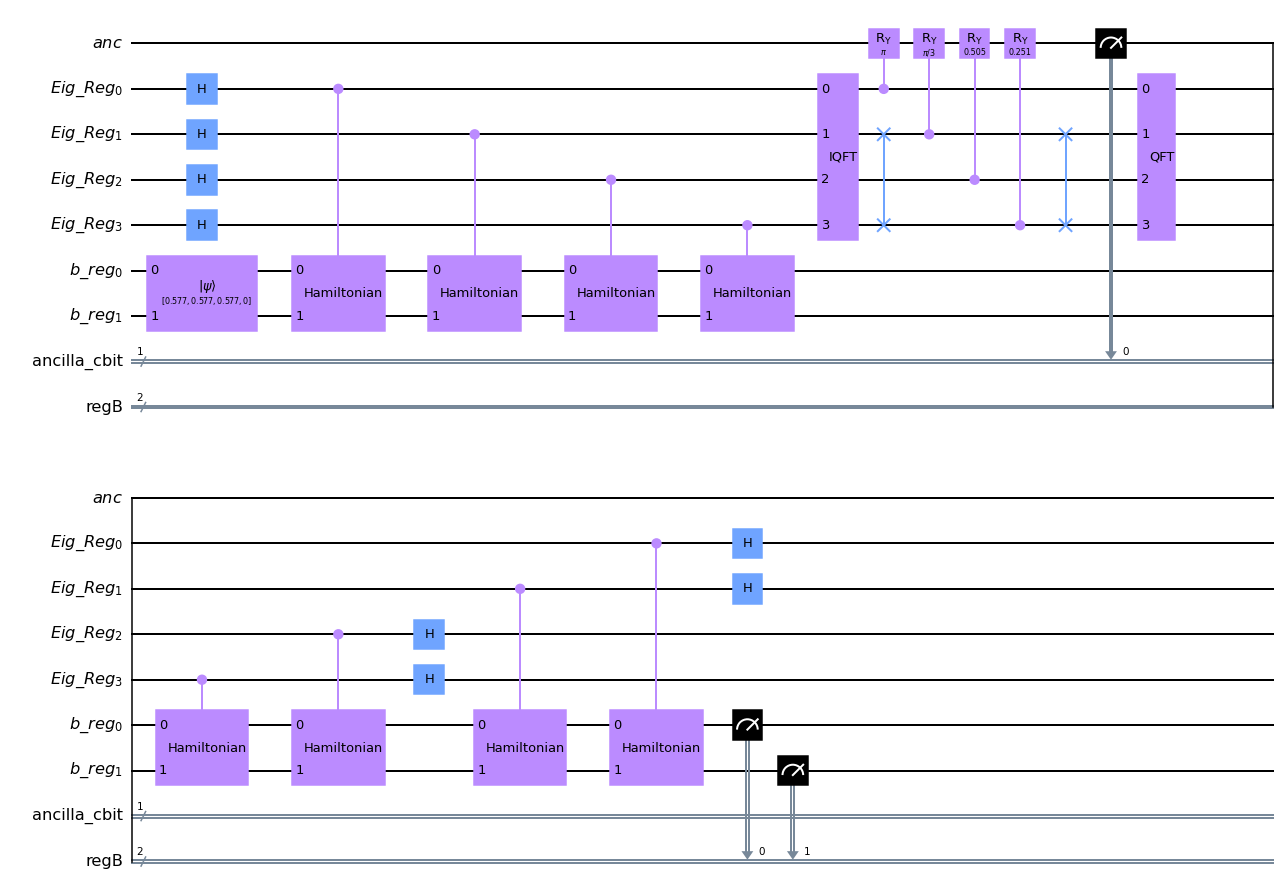

In [25]:
quantum_circuit.draw('mpl')

In [35]:
sim = Aer.get_backend("aer_simulator_statevector")
job = execute(quantum_circuit,backend=sim,shots=shots)

In [36]:
result = job.result()

In [37]:
vct = result.get_counts()
vct

{'00 1': 14492,
 '10 0': 2550,
 '10 1': 14445,
 '00 0': 2433,
 '01 0': 17259,
 '01 1': 28821}

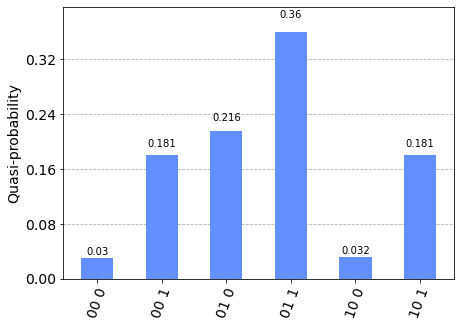

In [38]:
for key in vct:
    vct[key] *= (1/shots)
plot_histogram(vct)

In [39]:
x_sta = np.array([vct['00 1'],vct['01 1'],vct['10 1'],0])
x_sta = x_sta / np.linalg.norm(x_sta,2)
#x_sta = x_sta/np.linalg.norm(x_sta,2)
xnorm = np.linalg.norm(A_herm @ x_sta,2)
print(f'Norm of A*x = {xnorm}\tNorm of b = {beta}')
factor = 1/xnorm
print(factor)

Norm of A*x = 246.8451052659485	Norm of b = 0.008015413982918588
0.004051123472440784


In [31]:
np.sqrt(1/np.dot(A_herm@x_sta, A_herm@x_sta))

0.004100914053323345

In [32]:
A_herm @ b_q

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 4)

[ 0.        -0.18115   -0.3602625 -0.1805625  0.       ]


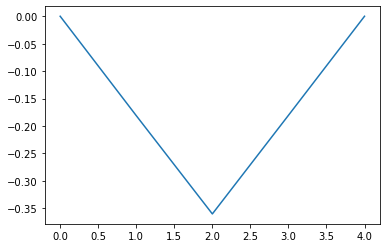

In [40]:
b_q = np.zeros(5)
b_q[1] = -vct['00 1']
b_q[2] = -vct['01 1']
b_q[3] = -vct['10 1']
#b_q = b_q*alpha
print(b_q)
plt.plot(b_q)

In [75]:
np.inner(b_q,b_q)

0.0012274912500000001

In [29]:
np.linalg.norm(w_n - b_q)

0.008907036073237454

In [30]:
factor

0.1670409402997725

In [67]:
quantum_circuit = transpile(quantum_circuit, basis_gates = ['u', 'cx'])

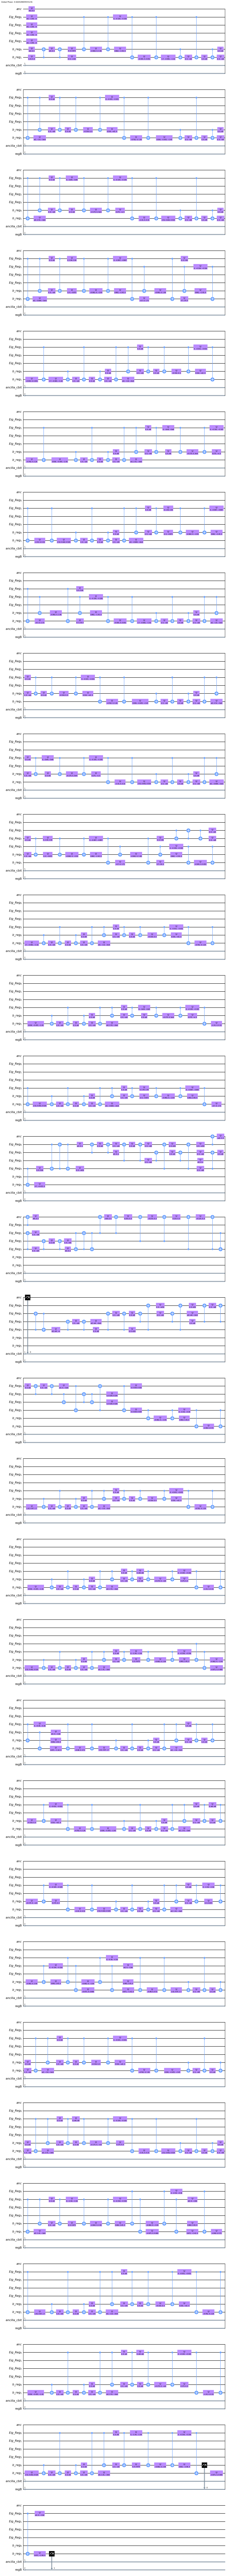

In [68]:
quantum_circuit.draw('mpl')

In [112]:
quantum_circuit.qasm(filename='qlsa_euler.qasm');

In [135]:
b_q

array([ 0.       , -0.2410625, -0.2816875, -0.2405125,  0.       ])

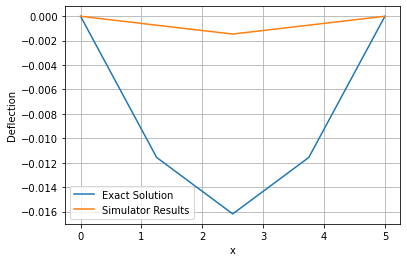

In [42]:
x = np.linspace(0,5,5)
#b_q = b_q*2.5
plt.plot(x,w_n,label='Exact Solution')
plt.plot(x,b_q*factor,label='Simulator Results')
plt.xlabel('x')
plt.ylabel('Deflection')
plt.legend()
plt.grid()

In [43]:
err_1 = w_n - factor*b_q/np.linalg.norm(b_q,2)
print(f'Relative Norm of Error for:\n1. Simulator = {np.linalg.norm(err_1)/np.linalg.norm(w_n)}')
#plt.plot(x,err_1,label='Simulator Error')
#plt.legend()
#plt.grid()

Relative Norm of Error for:
1. Simulator = 0.827220723141841


### Running Circuit as a 5x5 system

In [95]:
# Normalize the vector and apply the same factor to the matrix
b_herm = b_herm/np.linalg.norm(b_herm,2)
A_herm = A_herm/np.linalg.norm(b_herm,2)

# Condition number and Eigenvalues
print(np.linalg.cond(A_herm))
print(np.linalg.eigvals(A_herm))

# Number of Qubits needed to hold eigenvalues
eig_num = 4
# Number of Qubits needed to hold right side vector
b_num = int(np.log2(len(b_herm)))
# Hamiltonian Parameter --> Defines the total time for the Hamiltonial simulations
t = 2*np.pi
# Rotation parameter --> From paper on Quantum Circuit Design choose value between 5 and 6 for best results. We select 5 (for higher success rate)
r = 5
# Total number of circuit runs
shots = 40000

75.48675264248375
[ 12.28712763 -12.28712763   5.70156212  -5.70156212   2.
  -2.           0.70156212   0.16277197  -0.16277197  -0.70156212
   1.          -1.           1.          -1.           1.
  -1.        ]


In [96]:
qc_5x5 = construct_quantum_circuit(r,t)

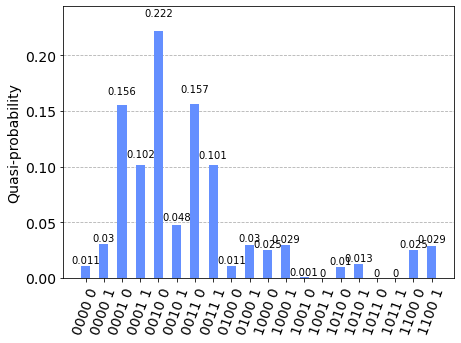

In [98]:
sim = Aer.get_backend("aer_simulator_statevector")
job = execute(qc_5x5,backend=sim,shots=shots)
result = job.result()
vct = result.get_counts()
for key in vct:
    vct[key] *= (1/shots)
plot_histogram(vct)